2018-02-08 21:25:57,014 Loading LFW people faces from /Users/omorillo/scikit_learn_data/lfw_home



Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces


/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.189s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.033s
Fitting the classifier to the training set
done in 17.712s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.048s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.38      0.48        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.94      0.81      0.87        36

      avg / total       0.85      0.84      

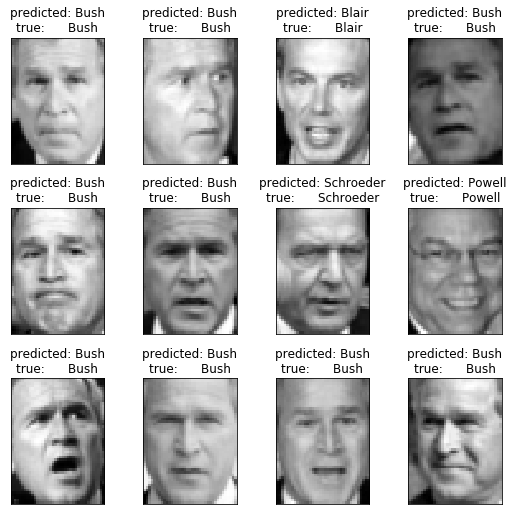

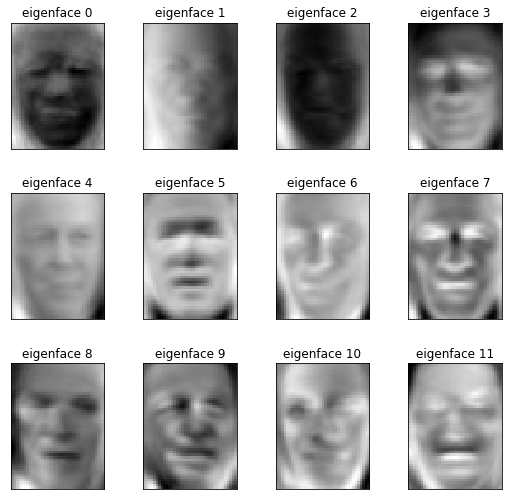

In [7]:
# %load "../pca/eigenfaces.py"
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


In [20]:
pca.explained_variance_ratio_[:2]

array([ 0.19346524,  0.15116848])

In [21]:
# The first and the second components explain 19.34% and 15.11% of the total variation in the data respectively.

In [22]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
for n_components in [10, 15, 25, 50, 100, 250]:
    print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print "done in %0.3fs" % (time() - t0)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print "Projecting the input data on the eigenfaces orthonormal basis"
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print "done in %0.3fs" % (time() - t0)


    ###############################################################################
    # Train a SVM classification model

    print "Fitting the classifier to the training set"
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print "done in %0.3fs" % (time() - t0)
    print "Best estimator found by grid search:"
    print clf.best_estimator_


    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print "Predicting the people names on the testing set"
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print "done in %0.3fs" % (time() - t0)

    print classification_report(y_test, y_pred, target_names=target_names)
    print confusion_matrix(y_test, y_pred, labels=range(n_classes))



Extracting the top 10 eigenfaces from 966 faces
done in 0.128s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.026s
Fitting the classifier to the training set


/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 43.847s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.008s
                   precision    recall  f1-score   support

     Ariel Sharon       0.09      0.15      0.11        13
     Colin Powell       0.41      0.47      0.44        60
  Donald Rumsfeld       0.27      0.41      0.32        27
    George W Bush       0.65      0.56      0.60       146
Gerhard Schroeder       0.19      0.20      0.19        25
      Hugo Chavez       0.20      0.13      0.16        15
       Tony Blair       0.52      0.39      0.44        36

      avg / total       0.48      0.45      0.46       322

[[ 2  6  1  3  1  0  0]
 [ 9 28  5 10  4  1  3]
 [ 2  7 11  5  1  0  1]
 [ 8 22 11 82 12  4  7]
 [ 0  1  4 11  5  2  2]
 

/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 13.438s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.009s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.38      0.43        13
     Colin Powell       0.68      0.73      0.70        60
  Donald Rumsfeld       0.50      0.52      0.51        27
    George W Bush       0.74      0.75      0.75       146
Gerhard Schroeder       0.50      0.40      0.44        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.59      0.64      0.61        36

      avg / total       0.66      0.66      0.66       322

[[  5   3   1   4   0   0   0]
 [  5  44   1   9   1   0   0]
 [  0   4  14   9   0   0   0]
 [  0  11  11 110   5   2   

/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 6.348s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.009s
                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.69      0.56        13
     Colin Powell       0.71      0.87      0.78        60
  Donald Rumsfeld       0.48      0.48      0.48        27
    George W Bush       0.87      0.82      0.85       146
Gerhard Schroeder       0.64      0.56      0.60        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.69      0.61      0.65        36

      avg / total       0.75      0.74      0.74       322

[[  9   2   1   1   0   0   0]
 [  3  52   3   1   0   0   1]
 [  5   3  13   5   0   0   1]
 [  2   9   8 120   4   0   

/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 5.772s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.016s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.81      0.90      0.85        60
  Donald Rumsfeld       0.62      0.56      0.59        27
    George W Bush       0.86      0.88      0.87       146
Gerhard Schroeder       0.75      0.72      0.73        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.80      0.67      0.73        36

      avg / total       0.80      0.80      0.80       322

[[  9   2   1   1   0   0   0]
 [  0  54   1   3   0   0   2]
 [  4   1  15   6   1   0   0]
 [  1   6   6 128   1   2   

/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.184s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.044s
Fitting the classifier to the training set
done in 10.777s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.031s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.81      0.90      0.85        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.90      0.76      0.83        25
      Hugo Chavez       1.00      0.67      0.80        15
       Tony Blair       0.87      0.75      0.81        36

      avg / total       0.86      0.86      

/Users/omorillo/anaconda3/envs/udacity-2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.185s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.036s
Fitting the classifier to the training set
done in 27.140s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.080s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.76      0.92      0.83        60
  Donald Rumsfeld       0.71      0.63      0.67        27
    George W Bush       0.94      0.89      0.92       146
Gerhard Schroeder       0.72      0.72      0.72        25
      Hugo Chavez       0.78      0.47      0.58        15
       Tony Blair       0.81      0.83      0.82        36

      avg / total       0.83      0.83      

Change n_components to the following values: [10, 15, 25, 50, 100, 250]. 
For each number of principal components, note the F1 score for Ariel Sharon. 
(For 10 PCs, the plotting functions in the code will break, but you should 
be able to see the F1 scores.) If you see a higher F1 score, does it mean 
the classifier is doing better, or worse?

**Answer:** A higher F1-score indicates a better performance.

Do you see any evidence of overfitting when using a large number of PCs? 
Does the dimensionality reduction of PCA seem to be helping your performance here?

**Answer:** Yes, there is an evidence. The f1-score is strongly monotone increasing but with 250 principal components the performance drops. Which shows the model started to fit noise.